# Introduction
* This kernel is notes that I took for **RNN and LSTM**. This is not a tutorial you can think that kernel as a cheatsheet for **RNN and LSTM**. While coding a kernel open this in a new tab and copy paste.

<img src = "https://miro.medium.com/max/4136/1*SKGAqkVVzT6co-sZ29ze-g.png" />

### This kernel is a part of a big series:
* [Data Science Notes1: Matplotlib](https://www.kaggle.com/mrhippo/data-science-notes1-matplotlib)
* [Data Science Notes2: Seaborn](https://www.kaggle.com/mrhippo/data-science-notes2-seaborn)
* [Data Science Notes3: Plotly](https://www.kaggle.com/mrhippo/data-science-notes3-plotly)
* [Data Science Notes4: Machine Learning (ML)](https://www.kaggle.com/mrhippo/data-science-notes4-machine-learning)
* [Data Science Notes5: Deep Learning: ANN](https://www.kaggle.com/mrhippo/data-science-notes5-deep-learning-ann)
* [Data Science Notes6: Deep Learning: CNN](https://www.kaggle.com/mrhippo/data-science-notes6-deep-learning-cnn) 
* Data Science Notes7: Deep Learning: RNN and LSTM

### This kernel will be updated

## Content
* [Imports](#1)
* [Exploring Data](#2)
* [RNN](#3)
* [LSTM](#4)
* [Conclusion](#5)

<a id="1"></a> <br>
# Imports

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id="2"></a> <br>
# Exploring Data

In [ ]:
data = pd.read_csv("/kaggle/input/international-airline-passengers/international-airline-passengers.csv", skipfooter = 5)

In [ ]:
data.head()

In [ ]:
data = data.rename(columns = {"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60" : "passengers"})

In [ ]:
data.info()

In [ ]:
data["Month"] = pd.to_datetime(data["Month"])

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(data["Month"],data["passengers"])
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Month-Passengers")
plt.show()

<a id="3"></a> <br>
# RNN
* RNN(Recurrent Neural Network) is a NN type that can **remember the past**. It **cannot remember everything** but this memory **enables them to predict future or continuation of a thing**. For example: Lets say we have a text that says: "I have sauce and pasta, I will make a ...". RNN can complete that text: "I have sauce and pasta, I will make a **sauced pasta**".

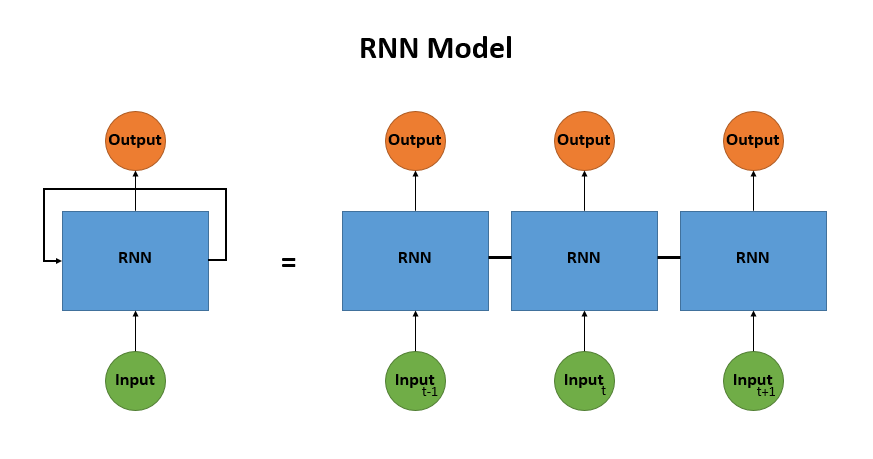

## Preparing Data

In [ ]:
data_lstm = data.iloc[:,1].values
data_lstm = data_lstm.reshape(-1,1)
data_lstm = data_lstm.astype("float32")
df = pd.DataFrame(data_lstm)
df.head()

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1)) # scaling
data_lstm = scaler.fit_transform(data_lstm)

In [ ]:
train_size = int(len(data_lstm)*0.50)
test_size = len(data_lstm) - train_size
train = data_lstm[0:train_size,:]
test = data_lstm[train_size:len(data_lstm),:]
print("train size: {}, test size: {}".format(len(train),len(test)))

In [ ]:
time_step = 2 
datax = []
datay = []
for i in range(len(test)-time_step-1):
    a = train[i:(i+time_step),0]
    datax.append(a)
    datay.append(test[i + time_step, 0])
trainx = np.array(datax)
trainy = np.array(datay)

### What is Time Step
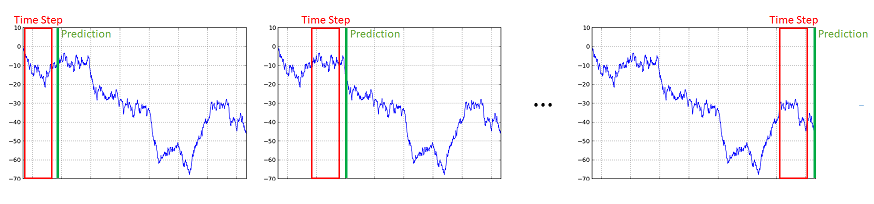

In [ ]:
datax = []
datay = []
for i in range(len(test)-time_step-1):
    a = test[i:(i+time_step),0]
    datax.append(a)
    datay.append(test[i + time_step, 0])
testx = np.array(datax)
testy = np.array(datay)

In [ ]:
trainx = np.reshape(trainx, (trainx.shape[0], 1 , trainx.shape[1]))
testx = np.reshape(testx, (testx.shape[0], 1 , testx.shape[1]))

## Modeling

In [ ]:
model = Sequential()

model.add(SimpleRNN(60, activation = "relu", return_sequences = True, input_shape = (1,time_step)))
model.add(Dropout(0.3))

model.add(SimpleRNN(50, activation = "relu", return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(50, activation = "relu", return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(40, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = "adam",
             loss = "mean_squared_error",
             metrics = ["accuracy"])

model.summary()

In [ ]:
hist = model.fit(trainx,trainy, epochs = 150, batch_size = 32)

## Results

In [ ]:
trainPredict = model.predict(trainx)
testPredict = model.predict(testx)

trainPredict = scaler.inverse_transform(trainPredict)
trainy = scaler.inverse_transform([trainy])
testPredict = scaler.inverse_transform(testPredict)
testy = scaler.inverse_transform([testy])

trainScore = math.sqrt(mean_squared_error(trainy[0], trainPredict[:,0]))
print("train score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(testy[0], testPredict[:,0]))
print("test score: %.2f RMSE" % (testScore))

lstm_loss = hist.history["loss"]
plt.figure(figsize = (13,3))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses-Epochs")
plt.grid(True, alpha = 0.5)
plt.plot(lstm_loss)
plt.show()

In [ ]:
trainPredictPlot = np.empty_like(data_lstm)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[time_step:len(trainPredict)+time_step, :] = trainPredict

testPredictPlot = np.empty_like(data_lstm)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(time_step*2)+1:len(data_lstm)-1,:] = testPredict

plt.figure(figsize = (13,8))
plt.plot(scaler.inverse_transform(data_lstm),label = "Real Data")
plt.plot(trainPredictPlot,label = "Train Predicted")
plt.plot(testPredictPlot, label = "Test Predicted")
plt.legend()
plt.grid(True, alpha = 0.4)
plt.show()

<a id="4"></a> <br>
# LSTM
* LSTM(Long Short Term Memory) is a variant of RNN. It has a **long term memory**. 

<img src = "https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg" />

## Preparing Data

In [ ]:
data_lstm = data.iloc[:,1].values
data_lstm = data_lstm.reshape(-1,1)
data_lstm = data_lstm.astype("float32")
df = pd.DataFrame(data_lstm)
df.head()

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_lstm = scaler.fit_transform(data_lstm)

In [ ]:
time_step = 10 #50
datax = []
datay = []
for i in range(len(test)-time_step-1):
    a = train[i:(i+time_step),0]
    datax.append(a)
    datay.append(test[i + time_step, 0])
trainx = np.array(datax)
trainy = np.array(datay)

In [ ]:
datax = []
datay = []
for i in range(len(test)-time_step-1):
    a = test[i:(i+time_step),0]
    datax.append(a)
    datay.append(test[i + time_step, 0])
testx = np.array(datax)
testy = np.array(datay)

In [ ]:
trainx = np.reshape(trainx, (trainx.shape[0], 1 , trainx.shape[1]))
testx = np.reshape(testx, (testx.shape[0], 1 , testx.shape[1]))

## Modeling

In [ ]:
model = Sequential()
model.add(LSTM(units = 10, input_shape = (1,time_step)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", 
              optimizer="adam",
             metrics = ["accuracy"])

model.summary()

In [ ]:
hist = model.fit(trainx,trainy, epochs = 40)

## Results

In [ ]:
trainPredict = model.predict(trainx)
testPredict = model.predict(testx)

trainPredict = scaler.inverse_transform(trainPredict)
trainy = scaler.inverse_transform([trainy])
testPredict = scaler.inverse_transform(testPredict)
testy = scaler.inverse_transform([testy])

trainScore = math.sqrt(mean_squared_error(trainy[0], trainPredict[:,0]))
print("train score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(testy[0], testPredict[:,0]))
print("test score: %.2f RMSE" % (testScore))

lstm_loss = hist.history["loss"]
plt.figure(figsize = (13,3))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses-Epochs")
plt.grid(True, alpha = 0.5)
plt.plot(lstm_loss)
plt.show()

In [ ]:
trainPredictPlot = np.empty_like(data_lstm)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[time_step:len(trainPredict)+time_step, :] = trainPredict

testPredictPlot = np.empty_like(data_lstm)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(time_step*2)+1:len(data_lstm)-1,:] = testPredict

plt.figure(figsize = (13,8))
plt.plot(scaler.inverse_transform(data_lstm),label = "Real Data")
plt.plot(trainPredictPlot,label = "Train Predicted")
plt.plot(testPredictPlot, label = "Test Predicted")
plt.legend()
plt.grid(True, alpha = 0.4)
plt.show()

<a id="5"></a> <br>
# Conclusion
* **If there is something wrong with this kernel please let me know in the comments.**

### You can check my other kernels here: https://www.kaggle.com/mrhippo/notebooks